## Overview
* How to Prepare Data for a Kaggle Competition
* Using sklearn preprocessing features with pipelines
* Intro to Using Tensorflow
* Writing a Custom Callback
* Making a Submission!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


# Reading the Data

In [2]:
train_df = pd.read_csv('../input/titanic/train.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Using ```.info``` is a quick way to investigate the data on a surface level. Now we can see each column name and how many values they have. It is clear that three columns, ```Age``` ```Cabin``` ```Embarked```, have some number of values missing. 

Sometimes it is useful to look at one full row to see which columns will be most beneficial while training our data.

In [4]:
train_df.loc[0]

PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                                 22
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object

First, we notice that the ```Survived``` category will not have any consequence if we drop the ```Name``` category. The ```Ticket``` class is also not going to be very useful. Keep in mind that the ```Ticket``` class would be categorical if we were to include it since not all of them are pure numbers. We will also drop ```PassengerId``` as it does not provide any useful information. For the purpose of this tutorial, we will not be using ```Cabin``` due to the large number of missing values.

In [5]:
#Drop Name and Ticket

train_df.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Before moving on, lets split ```train_df``` into ```X``` and ```y``` to prepare the data for training. 

In [6]:
X = train_df.drop('Survived', axis=1, inplace=False)
y = train_df['Survived']

print(f'Input features shape: {X.shape}')
print(f'Labels shape: {y.shape}')

Input features shape: (891, 7)
Labels shape: (891,)


## Data Analysis

In [7]:
#Import visualization libraries

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Lets quickly look at the target variable to see evidence of **data imbalance**. 

Text(0, 0.5, 'Number of Passengers')

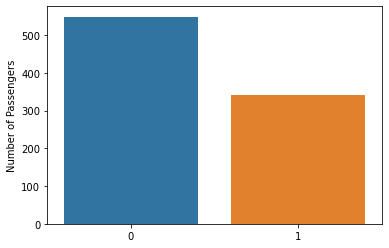

In [8]:
sns.barplot(x = y.unique(), y = y.value_counts())
plt.ylabel('Number of Passengers')

Fortunately, the imbalance isn't too bad for this dataset.

Now, let's see which features have missing values. 

   Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
0     891  891  714    891    891   891       889


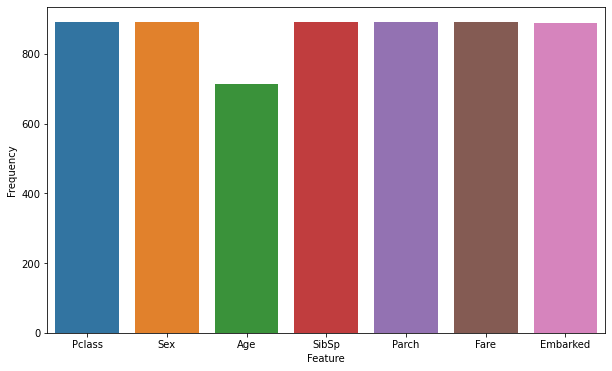

In [9]:
frequencies = X.count()

freq_df = pd.DataFrame([frequencies], columns=X.columns)
print(freq_df.head())

plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns, y = frequencies)
plt.ylabel('Frequency')
plt.xlabel('Feature')
plt.show()



From the above figure, it is clear that the ```Age``` category has a significant number of missing values. However, from the values listed we ```Embarked``` is missing 2 values in addition.

Fortunatly, Sci-kit Learn provides a nice and easy method to impute these missing values with the simple imputer. 

## Imputing and One-Hot Encoding

Imputing is the process of dealing with missing values. The most basic way to overcome this challenge would be to remove all the instances/rows which contain missing values. However, if we do that, then we would only have 714 training instances which is much less than 891. Therefore, we use the ```SimpleImputer``` API. 

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

'''
The following pipeline is only for numerical features:
1. Fill in Missing Values with Median value of existing numbers
2. Scale all the numbers to be in between 0 and 1
'''

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('std_scaler', StandardScaler())
])

'''
The following pipeline is only for categorical features:
1. Fill in Missing Values with Most Frequent value from existing data
2. One-hot encode (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
'''

cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder())
])


In [11]:
#Combine Pipelines

from sklearn.compose import ColumnTransformer

num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs), 
                                   ("cat", cat_pipeline, cat_attribs)])
X = full_pipeline.fit_transform(X)
X.shape

(891, 12)

Now that we have finished preparing the data, we are ready to split it into a train and validation set using ```train_test_split``` from sklearn.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network

Now that everything is ready, let's start building the model! We will see how we can use Tensorflow to create a simple neural network to solve this task. For now, we will use 2 hidden layers followed by the output layer with one nueron (binary problem). 

If you would like to get an in-depth understanding of how neural networks learn through back-propogation, please visit this tutorial on [Neural Networks from Scratch](https://www.kaggle.com/saumandas/neural-networks-from-scratch-tutorial). You will learn how to create a neural network from scratch to model the California Housing Dataset. 

In [13]:
#Import necessary libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L


Creating neural networks is pretty simple in tensorflow. Here are the steps:

1. Define Sequential model ```model = Sequential()```
2. Add Input Layer ```model.add(L.InputLayer(input_shape=...))``` --> Optional!
3. Add fully connected layers ```model.add(L.Dense(...))```
4. Compile Model
5. Callbacks (if necessary)
6. Train Model

Of course, more complex models can also be created, but we can conquer this dataset by using basic tensorflow API. 

In [14]:
#Step 1
model = Sequential(name='titanic_model')

#Step 2
model.add(L.InputLayer(input_shape=(12,))) # necessary to use model.summary()

#Step 3
model.add(L.Dense(512, activation='relu'))
model.add(L.Dense(1024, activation='relu'))
model.add(L.Dropout(0.4)) #prevents overfitting by setting 40% of nuerons to 0
model.add(L.Dense(512, activation='relu'))
model.add(L.Dropout(0.4))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(64, activation='relu'))
model.add(L.Dense(64, activation='relu'))
model.add(L.Dense(1, activation='sigmoid')) # output layer, use sigmoid for binary

model.summary()

Model: "titanic_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6656      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 64)              

In [15]:
#Step 4
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [16]:
'''
This custom callback stops training once the validation accuracy reaches 83%.
There are several callbacks already implemented by keras.
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

'''

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.83):
            print("\nReached 83% accuracy so cancelling training!")
            self.model.stop_training = True


#Step 6
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size=8, 
                    callbacks=[myCallback()],
                    epochs=50)

Epoch 1/50
89/89 [==============================] - 1s 12ms/step - loss: 0.6621 - accuracy: 0.6390 - val_loss: 0.5707 - val_accuracy: 0.7430
Epoch 2/50
89/89 [==============================] - 1s 10ms/step - loss: 0.4970 - accuracy: 0.7879 - val_loss: 0.4409 - val_accuracy: 0.8045
Epoch 3/50
89/89 [==============================] - 1s 9ms/step - loss: 0.4596 - accuracy: 0.8048 - val_loss: 0.4351 - val_accuracy: 0.8101
Epoch 4/50
89/89 [==============================] - 1s 9ms/step - loss: 0.4329 - accuracy: 0.8230 - val_loss: 0.4388 - val_accuracy: 0.8212
Epoch 5/50
89/89 [==============================] - 1s 9ms/step - loss: 0.4137 - accuracy: 0.8329 - val_loss: 0.4382 - val_accuracy: 0.8045
Epoch 6/50
89/89 [==============================] - 1s 12ms/step - loss: 0.4063 - accuracy: 0.8329 - val_loss: 0.4641 - val_accuracy: 0.8101
Epoch 7/50
84/89 [===========================>..] - ETA: 0s - loss: 0.4102 - accuracy: 0.8333
Reached 83% accuracy so cancelling training!
89/89 [===========

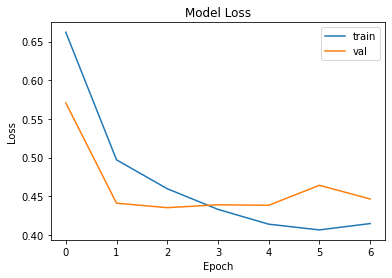

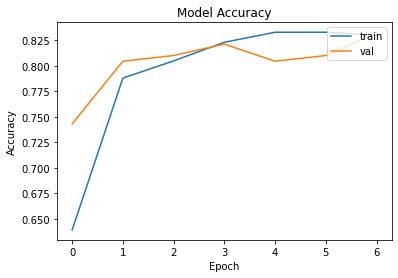

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper right')
plt.show()

From the plot above, hopefully it is clear that the train loss goes down consistently while the validation loss starts increasing after the first few epochs. This is a good sign of overfitting. 

# Prepare the Test Data

Again we have to drop the data as we did in the train data. Then we also have to transform it using the same pipeline as before. After that, we say the person survived if the prediction was greater then 0.5. Finally, we can make our submission.

In [18]:
test_df = pd.read_csv('../input/titanic/test.csv')
test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


In [19]:
test_prepared = full_pipeline.transform(test_df)
test_prepared.shape

(418, 12)

In [20]:
preds = model.predict(test_prepared)
preds[:5]

array([[0.1106396 ],
       [0.3152263 ],
       [0.0725987 ],
       [0.1024656 ],
       [0.28264302]], dtype=float32)

In [21]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')
submission['Survived'] = [0 if pred < 0.5 else 1 for pred in preds]
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [22]:
from IPython.display import FileLink


submission.to_csv('submission.csv',index=False)
FileLink(r'submission.csv')

/kaggle/working/submission.csv

**Please Upvote if you found this helpful!**
**Thanks**